In [1]:
import pandas as pd
import os


# 設定：パスとファイル名の定義
# ---------------------------------------------------------
DATA_DIR = './'
INPUT_STATS_FILE = 'stats_pit_dataset.csv'
INPUT_PLAY_FILE = 'play_info_dataset.csv'
OUTPUT_FILE = 'pitcher_summary_12players.csv'

PATH_STATS = os.path.join(DATA_DIR, INPUT_STATS_FILE)
PATH_PLAY = os.path.join(DATA_DIR, INPUT_PLAY_FILE)
PATH_OUTPUT = os.path.join(DATA_DIR, OUTPUT_FILE)


# 1. データの読み込み
# ---------------------------------------------------------

try:
    df_stats = pd.read_csv(PATH_STATS)
    df_play = pd.read_csv(PATH_PLAY)
except FileNotFoundError as e:
    print(f"ファイルが見つかりません。パスを確認してください: {e}")


# 集計ロジック
if 'era' not in df_stats.columns and 'er' in df_stats.columns:
    df_stats['era'] = df_stats.apply(
        lambda row: (row['er'] * 9) / row['ip'] if row['ip'] > 0 else 0.00, axis=1
    ).round(2)

viz_data_list = []

# 奪三振が多い順に処理
if 'so' in df_stats.columns:
    target_pitchers = df_stats.sort_values(by='so', ascending=False)
else:
    target_pitchers = df_stats 

for index, row in target_pitchers.iterrows():
    # カラム名が 'player_name' か 'pitcher_name' か確認して取得
    p_name = row.get('player_name', row.get('pitcher_name'))
    
    # その投手の全投球データ
    df_target = df_play[df_play['pitcher_name'] == p_name]
    
    if len(df_target) == 0:
        continue

    # --- A. 決め球データの抽出 ---
    ball_stats = df_target.groupby('pitch_type_name').agg(
        count=('pitch_type_name', 'count'),
        whiff=('is_swinging_strike', 'sum')
    ).reset_index()
    
    ball_stats['whiff_rate'] = ball_stats['whiff'] / ball_stats['count']
    
    # 最も空振り率が高い球（10球以上投げているもの）を探す
    valid_balls = ball_stats[ball_stats['count'] >= 10]
    
    if len(valid_balls) > 0:
        best_ball = valid_balls.sort_values('whiff_rate', ascending=False).iloc[0]
        best_ball_name = best_ball['pitch_type_name']
        best_ball_rate = best_ball['whiff_rate']
    else:
        best_ball_name = "データ不足"
        best_ball_rate = 0

    # --- B. 1行のデータにまとめる ---
    viz_data_list.append({
        '投手名': p_name,
        '防御率': row.get('era', 0), 
        '奪三振数': row.get('so', 0),
        '投球回': row.get('ip', 0),
        '決め球名': best_ball_name,       
        '決め球空振り率': round(best_ball_rate, 3), 
        '総投球数': len(df_target)        
    })


# データフレーム化 & CSV保存
df_viz = pd.DataFrame(viz_data_list)

display(df_viz)

# 指定したパスへ保存
df_viz.to_csv(PATH_OUTPUT, index=False, encoding='utf-8-sig') 


,投手名,防御率,奪三振数,投球回,決め球名,決め球空振り率,総投球数
0,伊藤 大海,2.53,195,196,スライダー,0.154,3072
1,村上 頌樹,2.11,144,175,チェンジアップ,0.241,2751
2,戸郷 翔征,4.14,87,111,フォーク,0.210,1990
3,大野 雄大,2.10,72,120,カットボール,0.137,1806
4,栗林 良吏,2.25,54,52,フォーク,0.198,806
5,平良 海馬,1.73,53,52,スライダー,0.167,862
6,鈴木 翔天,2.36,52,42,フォーク,0.253,744
7,横山 陸人,2.09,47,56,スライダー,0.253,871
8,大津 亮介,1.94,36,65,チェンジアップ,0.160,1043
9,山岡 泰輔,4.25,32,36,チェンジアップ,0.217,623


In [2]:
import pandas as pd
import os


# 設定
# ---------------------------------------------------------
DATA_DIR = './'
INPUT_PLAY_FILE = 'play_info_dataset.csv'
OUTPUT_FILE = 'pitcher_distribution_12players.csv'

PATH_PLAY = os.path.join(DATA_DIR, INPUT_PLAY_FILE)
PATH_OUTPUT = os.path.join(DATA_DIR, OUTPUT_FILE)

# 1. データの読み込み
# ---------------------------------------------------------

try:
    df_play = pd.read_csv(PATH_PLAY)
except FileNotFoundError:
    print("ファイルが見つかりません。")
    raise


# 2. データの正体を確認（ここが大事！）
# ---------------------------------------------------------
if 'batter_handedness' in df_play.columns:
    unique_hands = df_play['batter_handedness'].unique()
    print(f"   打者の利き腕の書き方: {unique_hands}") 
else:
    print("'batter_handedness' 列が見つかりません！")


# 3. 集計処理
# 上位12人を選出
top_pitchers = df_play['pitcher_name'].value_counts().head(12).index.tolist()

data_list = []

for p_name in top_pitchers:
    df_target = df_play[df_play['pitcher_name'] == p_name]
    

    # データに含まれる「利き腕」の種類すべてでループする
    existing_hands = df_target['batter_handedness'].dropna().unique()
    
    for hand in existing_hands:
        # ラベルを自動判定
        if hand in ['R', '右', 'Right']:
            label = "右打者"
        elif hand in ['L', '左', 'Left']:
            label = "左打者"
        else:
            label = f"打者({hand})" 
            
        # 集計
        df_hand = df_target[df_target['batter_handedness'] == hand]
        counts = df_hand['pitch_type_name'].value_counts(normalize=True)
        
        for ball, rate in counts.items():
            data_list.append({
                '投手名': p_name,
                '対戦打者': label,
                '球種': ball,
                '投球割合': round(rate * 100, 1)
            })


# 4. 保存
if len(data_list) > 0:
    df_distribution = pd.DataFrame(data_list)
    
    df_export = df_distribution.pivot_table(
        index=['投手名', '対戦打者'], 
        columns='球種', 
        values='投球割合'
    ).fillna(0)

    
    display(df_export)

    df_export.to_csv(PATH_OUTPUT, encoding='utf-8-sig') 
    
else:
    print("\nまだ集計できません。上の「診断結果」を見て、利き腕のカラム名や値を確認してください")

   打者の利き腕の書き方: ['左' '右']


球種          カットボール   カーブ  シュート  シンカー  ストレート  スライダー  チェンジアップ  フォーク  特殊球
投手名   対戦打者                                                            
伊藤　大海 右打者      0.9   2.5  11.2   0.0   41.0   28.8      0.3  15.2  0.0
      左打者      6.9   4.2   1.5   0.0   45.2   15.8      3.2  23.3  0.1
大津　亮介 右打者      7.1   4.8  16.2   0.0   27.0   10.4     12.4  22.0  0.0
      左打者     14.1   6.3   7.0   0.0   35.2    4.6     21.1  11.7  0.0
大野　雄大 右打者     20.2   3.8  30.0   0.0   44.2    0.0      1.1   0.7  0.0
      左打者     27.3   3.7  17.6   0.0   42.1    0.0      0.4   8.8  0.0
山岡　泰輔 右打者     14.5   0.4   2.2   0.0   33.3   41.7      8.0   0.0  0.0
      左打者     14.7   0.6   0.0   0.0   30.9   42.3     11.4   0.0  0.0
平良　海馬 右打者     16.5   0.0   8.0   0.0   46.8   26.4      0.8   1.5  0.0
      左打者     10.5   0.0   1.3   0.0   47.2   13.1     19.0   8.8  0.0
戸郷　翔征 右打者      0.2   5.0   0.0   0.0   54.9   18.4      0.0  21.5  0.0
      左打者      0.2   7.7   0.0   0.0   48.5   13.8      0.0  29.8  0.0
村上　頌樹 右打者      9.9   5.5   3.2   0.0   51.7   15.1     14.7   0.0  0.0
      左打者      8.3   7.8  13.3   0.0   47.7   10.4     12.5   0.0  0.0
栗林　良吏 右打者     15.7  20.4   0.0   0.0   36.4    0.0      0.0  27.5  0.0
      左打者     18.4  14.9   0.0   0.0   36.0    0.0      0.0  30.7  0.0
横山　陸人 右打者      4.6   0.0   0.0   9.6   59.9   25.9      0.0   0.0  0.0
      左打者      0.5   0.0   0.0  25.1   66.3    8.0      0.0   0.0  0.0
石川　雅規 右打者     17.8   3.6   7.3  27.5   25.1   12.1      6.5   0.0  0.0
      左打者     11.1   4.7  13.6  14.5   31.5   21.3      3.4   0.0  0.0
鈴木　翔天 右打者      0.0   0.0   0.0   0.0   64.6   14.4      0.0  21.0  0.0
      左打者      0.0   0.7   0.0   0.0   57.2   39.4      0.0   2.6  0.0
颯     右打者      0.0   0.0  35.2   0.0   23.3   41.4      0.0   0.0  0.0
      左打者      0.0   2.1  32.9   0.0   29.5   35.6      0.0   0.0  0.0

In [3]:
import pandas as pd
import os

# 設定：パスとファイル名の定義
# ---------------------------------------------------------
DATA_DIR = './'
INPUT_PLAY_FILE = 'play_info_dataset.csv'
OUTPUT_FILE = 'pitcher_surprise_analysis.csv'

PATH_PLAY = os.path.join(DATA_DIR, INPUT_PLAY_FILE)
PATH_OUTPUT = os.path.join(DATA_DIR, OUTPUT_FILE)


# 1. データの読み込み
# ---------------------------------------------------------
try:
    df_play = pd.read_csv(PATH_PLAY)
    
except FileNotFoundError:
    print("ファイルが見つかりません。")
    raise


# 2. 分析対象の決定（自動選出）
# statsファイルを使わず、データ内に実在する「投球数が多いトップ12人」を選びます
if 'pitcher_name' in df_play.columns:
    target_pitchers = df_play['pitcher_name'].value_counts().head(12).index.tolist()
    
else:
    print("'pitcher_name' 列がありません。")
    target_pitchers = []


# 3. 「世間の常識（セオリー）」を定義する
# カウントの状態を表す列を作る
# データによっては float型(1.0) になっている場合があるので、intに変換して文字にする
df_play['count_state'] = 'B' + df_play['pre_ball'].fillna(0).astype(int).astype(str) + '-' + 'S' + df_play['pre_strike'].fillna(0).astype(int).astype(str)

# リーグ全体での「カウント別・球種選択確率」を計算
league_tendency = df_play.groupby(['count_state', 'pitch_type_name']).size().reset_index(name='count')
count_totals = df_play.groupby('count_state').size().reset_index(name='total')
league_tendency = pd.merge(league_tendency, count_totals, on='count_state')
league_tendency['theory_prob'] = league_tendency['count'] / league_tendency['total']

# 確率辞書を作る
theory_map = dict(zip(zip(league_tendency['count_state'], league_tendency['pitch_type_name']), league_tendency['theory_prob']))


# 4. 各プレーの「サプライズ度」を計算
def calculate_surprise(row):
    key = (row['count_state'], row['pitch_type_name'])
    prob = theory_map.get(key, 0)
    return 1.0 - prob # 確率が低いほどサプライズ度が上がる

df_play['surprise_score'] = df_play.apply(calculate_surprise, axis=1)


# 5. サプライズの性質を分類

# 成功フラグ（空振り or 見逃しストライクなら 1）
df_play['is_success'] = ((df_play['is_swinging_strike'] == 1) | (df_play['is_called_strike'] == 1)).astype(int)

# 2種類のサプライズを計算
df_play['strategic_score'] = df_play['surprise_score'] * df_play['is_success']       # 攻め（成功）
df_play['random_score'] = df_play['surprise_score'] * (1 - df_play['is_success'])   # 無頓着（失敗）


# 6. 投手ごとに集計してリスト化
surprise_analysis = []

for p_name in target_pitchers:
    df_target = df_play[df_play['pitcher_name'] == p_name]
    
    if len(df_target) == 0:
        continue
        
    # 平均値を算出
    avg_surprise = df_target['surprise_score'].mean()
    avg_strategic = df_target['strategic_score'].mean()
    avg_random = df_target['random_score'].mean()
    
    surprise_analysis.append({
        '投手名': p_name,
        'サプライズ指数_総合': round(avg_surprise, 4),
        '攻めるサプライズ': round(avg_strategic, 4),   # 縦軸用
        '無頓着サプライズ': round(avg_random, 4)       # 横軸用
    })

# データフレーム化
df_surprise = pd.DataFrame(surprise_analysis)


# 7. CSVファイルとして保存

if not df_surprise.empty:
    df_surprise.to_csv(PATH_OUTPUT, index=False, encoding='utf-8-sig')
    
    display(df_surprise)
    
    
else:
    print("データが集計できませんでした。")

,投手名,サプライズ指数_総合,攻めるサプライズ,無頓着サプライズ
0,伊藤 大海,0.7467,0.2076,0.5390
1,村上 頌樹,0.7387,0.2014,0.5373
2,戸郷 翔征,0.7091,0.1983,0.5108
3,大野 雄大,0.7649,0.1991,0.5658
4,大津 亮介,0.8052,0.2023,0.6029
5,横山 陸人,0.6887,0.1874,0.5013
6,平良 海馬,0.7347,0.2064,0.5283
7,栗林 良吏,0.7884,0.2466,0.5418
8,鈴木 翔天,0.6805,0.1992,0.4813
9,山岡 泰輔,0.7774,0.2169,0.5605


In [4]:
import pandas as pd
import os


# 設定：パスとファイル名の定義
# ---------------------------------------------------------
DATA_DIR = './'
INPUT_PLAY_FILE = 'play_info_dataset.csv'
OUTPUT_FILE = 'pitcher_surprise_yearly.csv' # 年度別データ

PATH_PLAY = os.path.join(DATA_DIR, INPUT_PLAY_FILE)
PATH_OUTPUT = os.path.join(DATA_DIR, OUTPUT_FILE)


# 1. データの読み込み
# ---------------------------------------------------------
try:
    df_play = pd.read_csv(PATH_PLAY)

except FileNotFoundError:
    print("ファイルが見つかりません。")
    raise


# 2. 分析対象の決定（上位12名）
# 処理を軽くするため、投球数が多いトップ12人に絞ります
if 'pitcher_name' in df_play.columns:
    target_pitchers = df_play['pitcher_name'].value_counts().head(12).index.tolist()
else:
    print("'pitcher_name' 列がありません。")
    target_pitchers = []


# 3. 「世間の常識（セオリー）」を定義する
# カウントの状態を表す列を作る（NaN対策をしてint→str変換）
df_play['count_state'] = 'B' + df_play['pre_ball'].fillna(0).astype(int).astype(str) + '-' + 'S' + df_play['pre_strike'].fillna(0).astype(int).astype(str)

# リーグ全体での「カウント別・球種選択確率」を計算
league_tendency = df_play.groupby(['count_state', 'pitch_type_name']).size().reset_index(name='count')
count_totals = df_play.groupby('count_state').size().reset_index(name='total')
league_tendency = pd.merge(league_tendency, count_totals, on='count_state')
league_tendency['theory_prob'] = league_tendency['count'] / league_tendency['total']

# 確率辞書を作る
theory_map = dict(zip(zip(league_tendency['count_state'], league_tendency['pitch_type_name']), league_tendency['theory_prob']))


# 4. 各プレーの「サプライズ度」を計算
def calculate_surprise(row):
    key = (row['count_state'], row['pitch_type_name'])
    prob = theory_map.get(key, 0)
    return 1.0 - prob

# ここで時間がかかるので、分析対象の12人分だけ計算するようにフィルタリングします
df_target = df_play[df_play['pitcher_name'].isin(target_pitchers)].copy()

df_target['surprise_score'] = df_target.apply(calculate_surprise, axis=1)

# 成功フラグ
df_target['is_success'] = ((df_target['is_swinging_strike'] == 1) | (df_target['is_called_strike'] == 1)).astype(int)

# スコア計算
df_target['strategic_score'] = df_target['surprise_score'] * df_target['is_success']
df_target['random_score'] = df_target['surprise_score'] * (1 - df_target['is_success'])


# 5. 年度ごとに集計
surprise_analysis = []

# 投手名 AND 年度 でグループ化
# game_yearがない場合はエラー回避
if 'game_year' in df_target.columns:
    grouped = df_target.groupby(['pitcher_name', 'game_year'])

    for (p_name, year), group in grouped:
        
        
        if len(group) < 30: 
            continue

        avg_strategic = group['strategic_score'].mean()
        avg_random = group['random_score'].mean()
        
        surprise_analysis.append({
            '投手名': p_name,
            '年度': year,
            'ラベル': f"{p_name}({year})",
            '攻めるサプライズ': round(avg_strategic, 4),
            '無頓着サプライズ': round(avg_random, 4),
            '投球数': len(group)
        })
else:
    print("'game_year' 列が見つかりません！年度別集計ができません。")


# 6. CSV保存
if len(surprise_analysis) > 0:
    df_surprise_yearly = pd.DataFrame(surprise_analysis)
    
    # ソート（投手名→年度順）
    df_surprise_yearly = df_surprise_yearly.sort_values(['投手名', '年度'])

    
    display(df_surprise_yearly.head(10)) # 確認用
    
    df_surprise_yearly.to_csv(PATH_OUTPUT, index=False, encoding='utf-8-sig')
    
    
else:
    print("データが集計できませんでした。")

,投手名,年度,ラベル,攻めるサプライズ,無頓着サプライズ,投球数
0,伊藤 大海,2025,伊藤 大海(2025),0.2076,0.5390,3072
1,大津 亮介,2025,大津 亮介(2025),0.2023,0.6029,1043
2,大野 雄大,2025,大野 雄大(2025),0.1991,0.5658,1806
3,山岡 泰輔,2025,山岡 泰輔(2025),0.2169,0.5605,623
4,平良 海馬,2025,平良 海馬(2025),0.2064,0.5283,862
5,戸郷 翔征,2025,戸郷 翔征(2025),0.1983,0.5108,1990
6,村上 頌樹,2025,村上 頌樹(2025),0.2014,0.5373,2751
7,栗林 良吏,2025,栗林 良吏(2025),0.2466,0.5418,806
8,横山 陸人,2025,横山 陸人(2025),0.1874,0.5013,871
9,石川 雅規,2025,石川 雅規(2025),0.1861,0.6474,526


📈 1. 配球グラフを作成中...


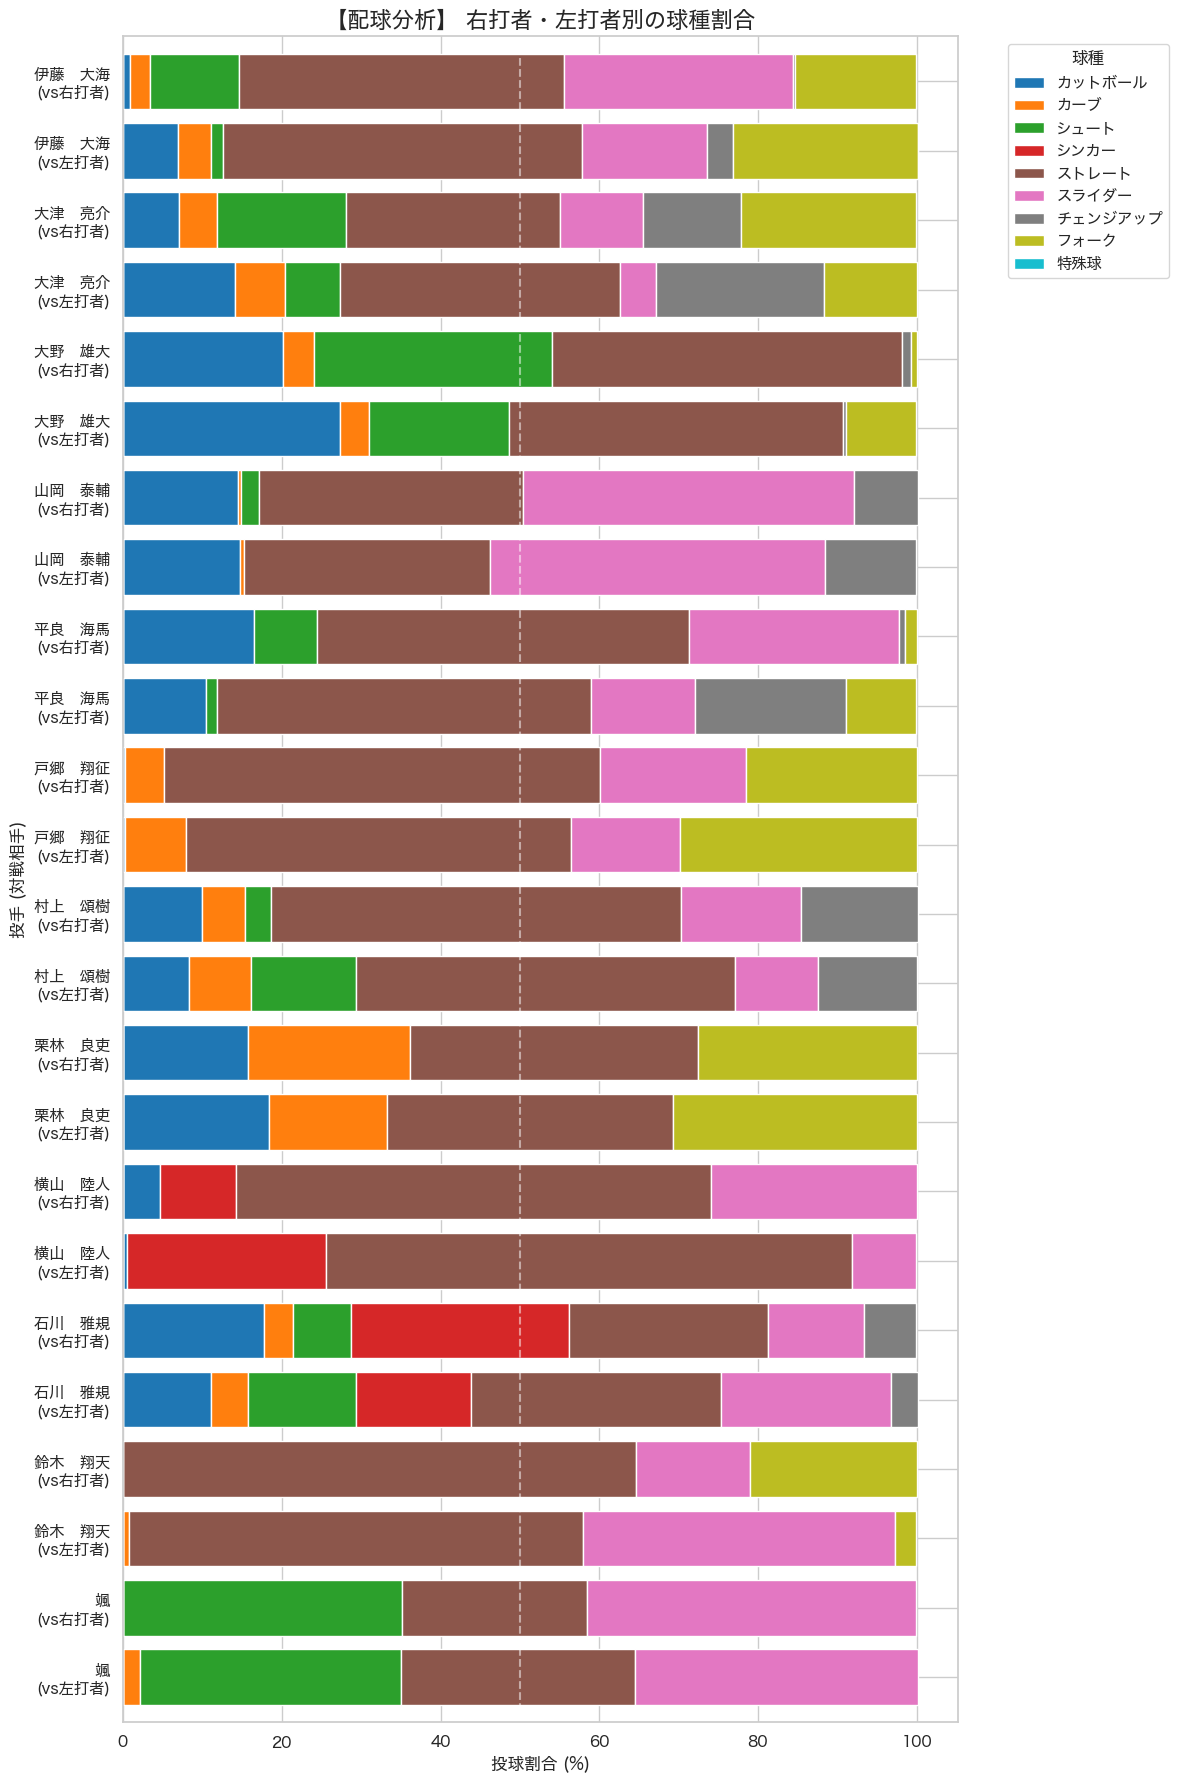

📈 2. 総合力グラフを作成中...


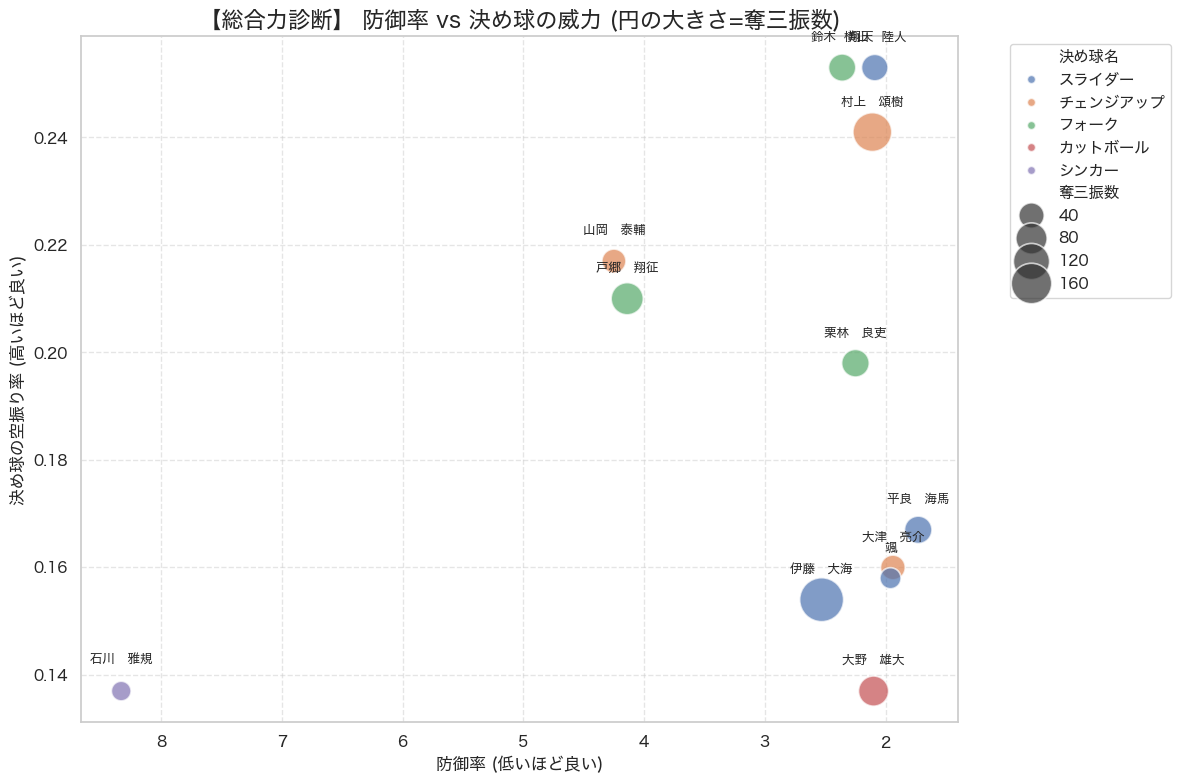

📈 3. タイプ診断グラフを作成中...


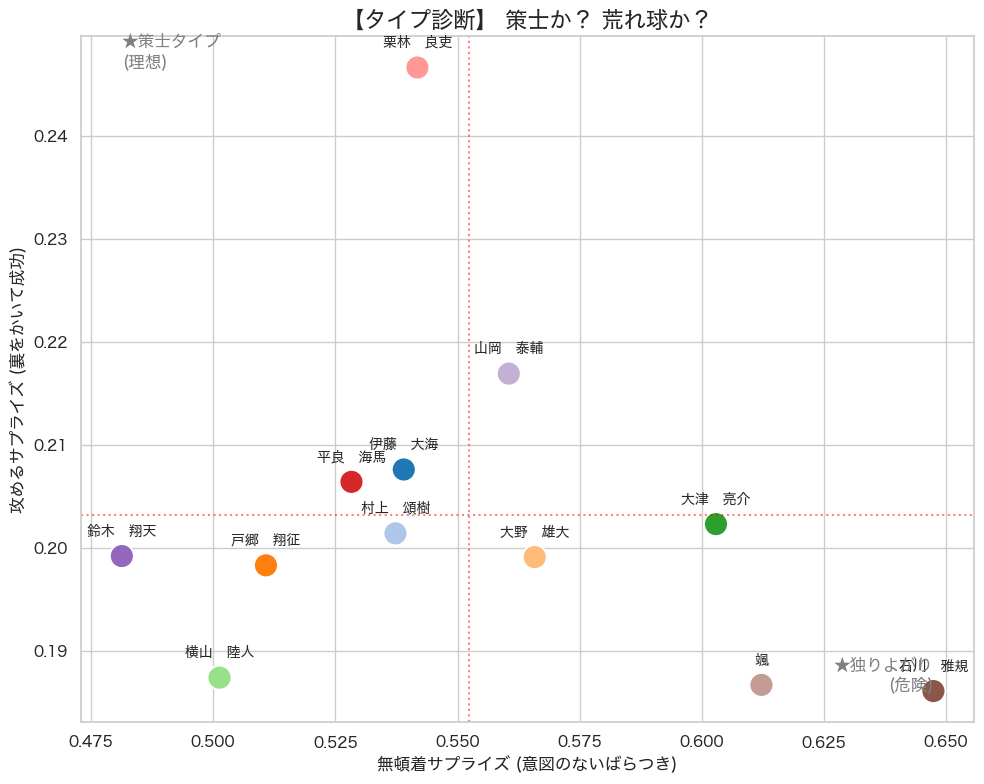

📈 4. 進化の軌跡グラフを作成中...


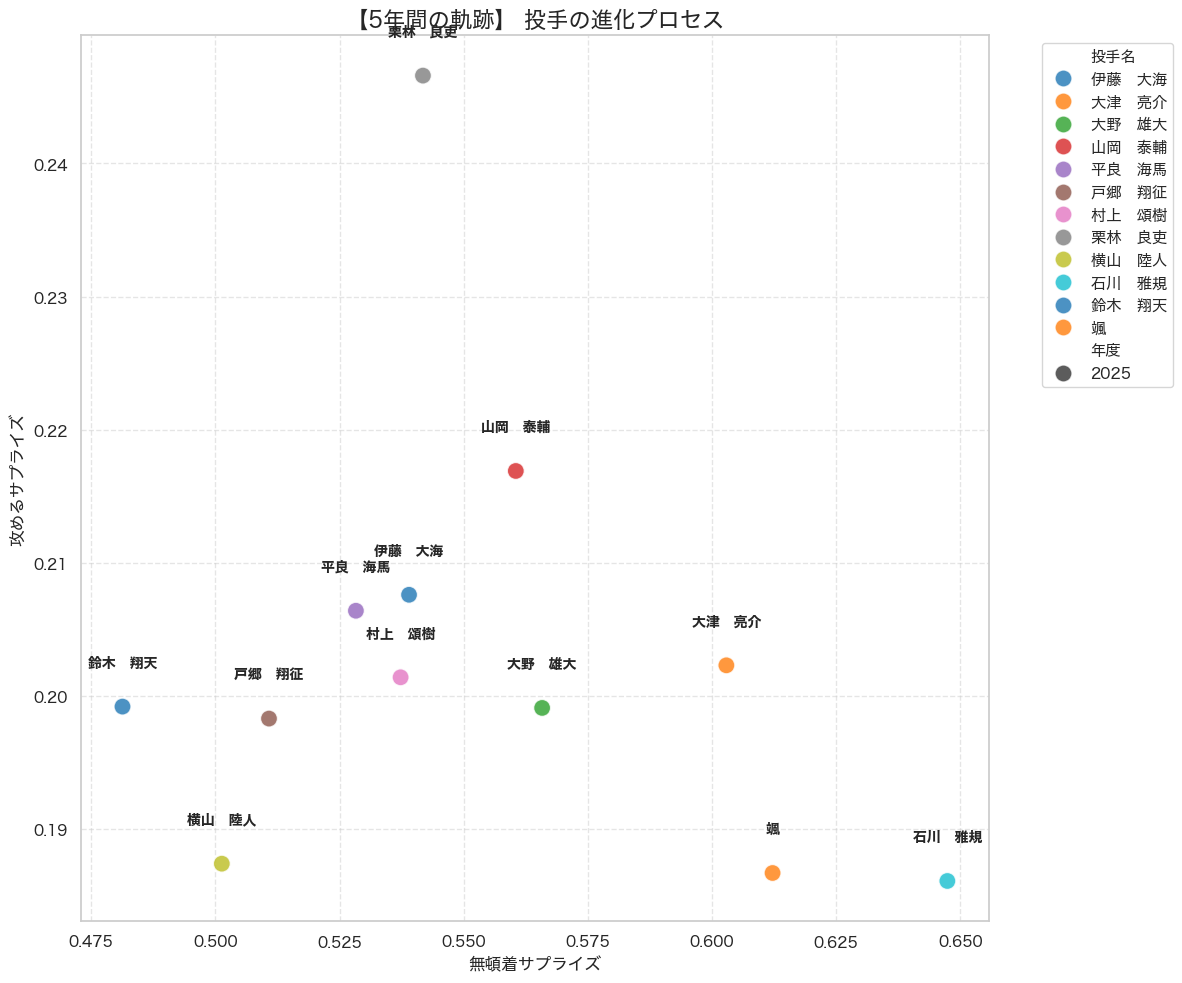

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import os

# ---------------------------------------------------------
# ⚙️ 設定：データがある場所
# ---------------------------------------------------------
# さっきCSVを保存した場所を指定してください
DATA_DIR = './' 

# ---------------------------------------------------------
# ⚙️ 設定：日本語フォント（文字化け防止）
# ---------------------------------------------------------
system_name = platform.system()
if system_name == 'Darwin': # Mac
    plt.rcParams['font.family'] = 'Hiragino Sans'
elif system_name == 'Windows': # Windows
    plt.rcParams['font.family'] = 'Meiryo'

# グラフのスタイル設定
sns.set(style="whitegrid", font=plt.rcParams['font.family'])

# =========================================================
# 📊 1. 配球割合（帯グラフ）
# =========================================================
file_1 = os.path.join(DATA_DIR, 'pitcher_distribution_12players.csv')

try:
    print("📈 1. 配球グラフを作成中...")
    df_dist = pd.read_csv(file_1)
    
    # グラフ用にデータを整形（投手名と対戦打者をくっつけたラベルを作る）
    df_dist['ラベル'] = df_dist['投手名'] + '\n(vs' + df_dist['対戦打者'] + ')'
    
    # 描画用にインデックスをセット
    df_dist = df_dist.set_index('ラベル')
    
    # 数値データだけにする（投手名などの列を削除）
    plot_data = df_dist.select_dtypes(include=['number'])
    
    # 積み上げ棒グラフ描画
    ax = plot_data.plot(kind='barh', stacked=True, figsize=(12, 18), colormap='tab10', width=0.8)
    
    plt.title('【配球分析】 右打者・左打者別の球種割合', fontsize=16)
    plt.xlabel('投球割合 (%)', fontsize=12)
    plt.ylabel('投手 (対戦相手)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='球種')
    plt.axvline(x=50, color='white', linestyle='--', alpha=0.5) # 真ん中の線
    plt.gca().invert_yaxis() # 上から順に並べる
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"⚠️ Graph 1 Skipped: {e}")


# =========================================================
# 📊 2. 投手総合力（バブルチャート）
# =========================================================
file_2 = os.path.join(DATA_DIR, 'pitcher_summary_12players.csv')

try:
    print("📈 2. 総合力グラフを作成中...")
    df_sum = pd.read_csv(file_2)
    
    plt.figure(figsize=(12, 8))
    
    # 散布図描画
    sns.scatterplot(
        data=df_sum,
        x='防御率', 
        y='決め球空振り率',
        size='奪三振数',   # バブルの大きさ
        sizes=(200, 1000), # バブルの最小・最大サイズ
        hue='決め球名',    # 色分け
        palette='deep',
        alpha=0.7
    )
    
    # 名前を表示
    for i, row in df_sum.iterrows():
        plt.text(row['防御率'], row['決め球空振り率']+0.005, row['投手名'], fontsize=9, ha='center')
        
    plt.title('【総合力診断】 防御率 vs 決め球の威力 (円の大きさ=奪三振数)', fontsize=16)
    plt.xlabel('防御率 (低いほど良い)', fontsize=12)
    plt.ylabel('決め球の空振り率 (高いほど良い)', fontsize=12)
    plt.gca().invert_xaxis() # 防御率は左に行くほど良いので反転
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"⚠️ Graph 2 Skipped: {e}")


# =========================================================
# 📊 3. サプライズ診断（タイプ分類散布図）
# =========================================================
file_3 = os.path.join(DATA_DIR, 'pitcher_surprise_analysis.csv')

try:
    print("📈 3. タイプ診断グラフを作成中...")
    df_surp = pd.read_csv(file_3)
    
    plt.figure(figsize=(10, 8))
    
    sns.scatterplot(
        data=df_surp,
        x='無頓着サプライズ',
        y='攻めるサプライズ',
        s=300, hue='投手名', palette='tab20', legend=False
    )
    
    for i, row in df_surp.iterrows():
        plt.text(row['無頓着サプライズ'], row['攻めるサプライズ']+0.002, row['投手名'], fontsize=10, ha='center')
        
    # 十字線（平均値）
    plt.axvline(x=df_surp['無頓着サプライズ'].mean(), color='red', linestyle=':', alpha=0.5)
    plt.axhline(y=df_surp['攻めるサプライズ'].mean(), color='red', linestyle=':', alpha=0.5)
    
    # エリアラベル
    plt.text(df_surp['無頓着サプライズ'].min(), df_surp['攻めるサプライズ'].max(), '★策士タイプ\n(理想)', fontsize=12, color='gray', ha='left')
    plt.text(df_surp['無頓着サプライズ'].max(), df_surp['攻めるサプライズ'].min(), '★独りよがり\n(危険)', fontsize=12, color='gray', ha='right')

    plt.title('【タイプ診断】 策士か？ 荒れ球か？', fontsize=16)
    plt.xlabel('無頓着サプライズ (意図のないばらつき)', fontsize=12)
    plt.ylabel('攻めるサプライズ (裏をかいて成功)', fontsize=12)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"⚠️ Graph 3 Skipped: {e}")


# =========================================================
# 📊 4. 進化の軌跡（時系列散布図）
# =========================================================
file_4 = os.path.join(DATA_DIR, 'pitcher_surprise_yearly.csv')

try:
    print("📈 4. 進化の軌跡グラフを作成中...")
    df_yearly = pd.read_csv(file_4)
    
    plt.figure(figsize=(12, 10))
    
    # 点を打つ
    sns.scatterplot(
        data=df_yearly,
        x='無頓着サプライズ', y='攻めるサプライズ',
        hue='投手名', style='年度', s=150, palette='tab10', alpha=0.8
    )
    
    # 線をつなぐ（軌跡）
    for p_name in df_yearly['投手名'].unique():
        df_p = df_yearly[df_yearly['投手名'] == p_name].sort_values('年度')
        plt.plot(df_p['無頓着サプライズ'], df_p['攻めるサプライズ'], color='gray', alpha=0.3, linestyle='--', linewidth=1)
        
        # 最新年に名前を表示
        last = df_p.iloc[-1]
        plt.text(last['無頓着サプライズ'], last['攻めるサプライズ']+0.003, p_name, fontsize=10, fontweight='bold', ha='center')

    plt.title('【5年間の軌跡】 投手の進化プロセス', fontsize=16)
    plt.xlabel('無頓着サプライズ', fontsize=12)
    plt.ylabel('攻めるサプライズ', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"⚠️ Graph 4 Skipped: {e}")